In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    get_linear_schedule_with_warmup
)
from datasets import Dataset as HFDataset, load_dataset
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    classification_report, cohen_kappa_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
from typing import Dict, List, Tuple, Optional
import logging
from datetime import datetime

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class RobertaDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int = 512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
class RobertaTrainer:
    
    def __init__(self, model_name: str = "roberta-base", max_length: int = 512):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = None
        self.sentiment_model = None
        self.emotion_model = None
        self.sentiment_label_encoder = LabelEncoder()
        self.emotion_label_encoder = LabelEncoder()
        
        # Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")
        
        # Create output directories
        os.makedirs("./roberta_sentiment_model", exist_ok=True)
        os.makedirs("./roberta_emotion_model", exist_ok=True)
        os.makedirs("./plots/roberta", exist_ok=True)
        os.makedirs("./results/roberta", exist_ok=True)
    
    def setup_tokenizer(self):
        logger.info("Setting up RoBERTa tokenizer...")
        self.tokenizer = RobertaTokenizer.from_pretrained(self.model_name)
        
        # Add padding token if it doesn't exist
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        logger.info("✅ Tokenizer ready!")
    
    def load_reddit_data(self, file_path: str) -> pd.DataFrame:
        logger.info(f"Loading Reddit data from {file_path}...")
        
        try:
            df = pd.read_csv(file_path)
            logger.info(f"✅ Loaded {len(df)} samples from Reddit dataset")
            
            # Check for required columns
            required_cols = ['text_content', 'sentiment', 'emotion']
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Missing required columns: {missing_cols}")
            
            # Remove rows with missing values
            df = df.dropna(subset=required_cols)
            logger.info(f"After removing missing values: {len(df)} samples")
            
            return df
            
        except Exception as e:
            logger.error(f"Error loading Reddit data: {e}")
            raise
    
    def load_external_datasets(self) -> Tuple[Dict, Dict]:
        logger.info("Loading external datasets...")
        
        # Load SST-2 for sentiment
        try:
            sst2_dataset = load_dataset("sst2")
            sentiment_data = {
                'train': sst2_dataset['train'],
                'validation': sst2_dataset['validation']
            }
            logger.info("✅ SST-2 dataset loaded for sentiment classification")
        except Exception as e:
            logger.warning(f"Could not load SST-2: {e}. Using dummy data.")
            sentiment_data = self._create_dummy_sentiment_data()
        
        # Load GoEmotions for emotion
        try:
            emotions_dataset = load_dataset("go_emotions", "simplified")
            emotion_data = {
                'train': emotions_dataset['train'],
                'validation': emotions_dataset['validation']
            }
            logger.info("✅ GoEmotions dataset loaded for emotion classification")
        except Exception as e:
            logger.warning(f"Could not load GoEmotions: {e}. Using dummy data.")
            emotion_data = self._create_dummy_emotion_data()
        
        return sentiment_data, emotion_data
    
    def _create_dummy_sentiment_data(self) -> Dict:
        dummy_texts = [
            "I love this product!", "This is terrible", "It's okay",
            "Amazing quality", "Worst experience ever", "Not bad"
        ] * 100
        dummy_labels = [1, 0, 1, 1, 0, 1] * 100
        
        dummy_data = {
            'sentence': dummy_texts,
            'label': dummy_labels
        }
        
        dataset = HFDataset.from_dict(dummy_data)
        return {'train': dataset, 'validation': dataset.select(range(100))}
    
    def _create_dummy_emotion_data(self) -> Dict:
        """Create dummy emotion data for testing"""
        dummy_texts = [
            "I'm so happy!", "This is sad", "I'm angry", "That's scary",
            "What a surprise!", "Okay", "I admire you", "That's funny"
        ] * 100
        dummy_labels = [0, 1, 2, 3, 4, 5, 6, 7] * 100
        
        dummy_data = {
            'text': dummy_texts,
            'labels': dummy_labels
        }
        
        dataset = HFDataset.from_dict(dummy_data)
        return {'train': dataset, 'validation': dataset.select(range(100))}
    
    def preprocess_external_data(self, dataset: Dict, task: str) -> Dict:
        """Preprocess external datasets"""
        logger.info(f"Preprocessing external data for {task}...")

        # --- ADD THIS BLOCK FOR EMOTION TASK ---
        if task == 'emotion':
            # Only keep samples with label in [0, 1, 2, 3, 4, 5]
            def filter_first_6_classes(example):
                # Handle both single-label and multi-label
                if isinstance(example['labels'], list):
                    return example['labels'] and example['labels'][0] in range(6)
                else:
                    return example['labels'] in range(6)
            dataset['train'] = dataset['train'].filter(filter_first_6_classes)
            dataset['validation'] = dataset['validation'].filter(filter_first_6_classes)
        # --- END BLOCK ---

        def tokenize_function(examples):
            if task == 'sentiment':
                texts = examples['sentence']
                labels = examples['label']
            else:  # emotion
                texts = examples['text']
                # Handle multi-label to single-label conversion
                if isinstance(examples['labels'][0], list):
                    labels = [label_list[0] if label_list else 0 for label_list in examples['labels']]
                else:
                    labels = examples['labels']

            tokenized = self.tokenizer(
                texts,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors=None
            )

            tokenized['labels'] = labels
            return tokenized

        # Tokenize datasets
        tokenized_train = dataset['train'].map(tokenize_function, batched=True)
        tokenized_val = dataset['validation'].map(tokenize_function, batched=True)

        # Take subsets for faster training
        train_subset = tokenized_train.shuffle(seed=42).select(range(min(10000, len(tokenized_train))))
        val_subset = tokenized_val.shuffle(seed=42).select(range(min(2000, len(tokenized_val))))

        logger.info(f"✅ Preprocessed {task} data: {len(train_subset)} train, {len(val_subset)} val")

        return {'train': train_subset, 'validation': val_subset}
    
    def train_model(self, dataset: Dict, task: str, num_labels: int, 
                   learning_rate: float = 2e-5, num_epochs: int = 3,
                   batch_size: int = 16) -> Tuple[any, any]:
        """Train RoBERTa model for specific task"""
        logger.info(f"Training RoBERTa model for {task} classification...")
        
        # Initialize model
        model = RobertaForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        
        # Training arguments
        output_dir = f"./roberta_{task}_model"
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir=f"./logs_{task}",
            logging_steps=100,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_accuracy",
            learning_rate=learning_rate,
            report_to=None,
            save_total_limit=2,
            dataloader_num_workers=0,  # Avoid multiprocessing issues
        )
        
        # Data collator
        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        
        # Compute metrics function
        def compute_metrics(eval_pred):
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, predictions, average='macro', zero_division=0
            )
            accuracy = accuracy_score(labels, predictions)
            
            return {
                'accuracy': accuracy,
                'f1': f1,
                'precision': precision,
                'recall': recall
            }
        
        # Initialize trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset['train'],
            eval_dataset=dataset['validation'],
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        
        # Train
        logger.info(f"🚀 Starting {task} model training...")
        trainer.train()
        
        # Save model
        final_output_dir = f"./roberta_{task}_model_final"
        os.makedirs(final_output_dir, exist_ok=True)
        trainer.save_model(final_output_dir)
        
        logger.info(f"✅ {task.capitalize()} model training completed!")
        
        return model, trainer
    
    def prepare_reddit_data(self, df: pd.DataFrame, task: str) -> Tuple[List[str], List[int]]:
        """Prepare Reddit data for training/evaluation"""
        texts = df['text_content'].tolist()
        
        if task == 'sentiment':
            labels = df['sentiment'].tolist()
            encoded_labels = self.sentiment_label_encoder.fit_transform(labels)
        else:  # emotion
            labels = df['emotion'].tolist()
            encoded_labels = self.emotion_label_encoder.fit_transform(labels)
        
        return texts, encoded_labels.tolist()
    
    def evaluate_model(self, model, texts: List[str], true_labels: List[int], 
                      task: str, label_encoder) -> Dict:
        """Comprehensive model evaluation"""
        logger.info(f"Evaluating {task} model...")
        
        # Prepare data
        dataset = RobertaDataset(texts, true_labels, self.tokenizer, self.max_length)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
        
        # Get predictions
        model.eval()
        predictions = []
        prediction_probs = []
        
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                
                # Get predictions and probabilities
                probs = torch.softmax(logits, dim=-1)
                preds = torch.argmax(logits, dim=-1)
                
                predictions.extend(preds.cpu().numpy())
                prediction_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            true_labels, predictions, average='macro', zero_division=0
        )
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            true_labels, predictions, average='weighted', zero_division=0
        )
        
        # Cohen's Kappa
        kappa = cohen_kappa_score(true_labels, predictions)
        
        # Confusion Matrix
        cm = confusion_matrix(true_labels, predictions)
        
        # Classification Report
        class_report = classification_report(
            true_labels, predictions, 
            target_names=label_encoder.classes_, 
            output_dict=True, zero_division=0
        )
        
        results = {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'precision_weighted': precision_weighted,
            'recall_weighted': recall_weighted,
            'f1_weighted': f1_weighted,
            'cohen_kappa': kappa,
            'confusion_matrix': cm,
            'classification_report': class_report,
            'predictions': predictions,
            'prediction_probs': prediction_probs,
            'true_labels': true_labels,
            'label_names': label_encoder.classes_
        }
        
        # Print results
        logger.info(f"\n{task.upper()} CLASSIFICATION RESULTS:")
        logger.info("=" * 50)
        logger.info(f"Accuracy:           {accuracy:.4f}")
        logger.info(f"Precision (macro):  {precision_macro:.4f}")
        logger.info(f"Recall (macro):     {recall_macro:.4f}")
        logger.info(f"F1-score (macro):   {f1_macro:.4f}")
        logger.info(f"F1-score (weighted): {f1_weighted:.4f}")
        logger.info(f"Cohen's Kappa:      {kappa:.4f}")
        
        return results
    
    def create_confusion_matrix(self, results: Dict, task: str, save_path: str = None):
        """Create and save confusion matrix"""
        cm = results['confusion_matrix']
        labels = results['label_names']
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=labels, yticklabels=labels)
        plt.title(f'{task.capitalize()} Classification - Confusion Matrix', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        
        if save_path:
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Confusion matrix saved to {save_path}")
        
        plt.show()
    
    def create_roc_curves(self, results: Dict, task: str, save_path: str = None):
        """Create ROC curves for multi-class classification"""
        y_true = results['true_labels']
        y_prob = np.array(results['prediction_probs'])
        labels = results['label_names']
        n_classes = len(labels)
        
        # Binarize labels for multi-class ROC
        from sklearn.preprocessing import label_binarize
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        
        plt.figure(figsize=(12, 8))
        
        # Calculate ROC curve for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curves
        colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'{task.capitalize()} Classification - ROC Curves', 
                 fontsize=16, fontweight='bold')
        plt.legend(loc="lower right")
        
        if save_path:
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"ROC curves saved to {save_path}")
        
        plt.show()
    
    def create_precision_recall_curves(self, results: Dict, task: str, save_path: str = None):
        """Create Precision-Recall curves"""
        y_true = results['true_labels']
        y_prob = np.array(results['prediction_probs'])
        labels = results['label_names']
        n_classes = len(labels)
        
        # Binarize labels
        from sklearn.preprocessing import label_binarize
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        
        plt.figure(figsize=(12, 8))
        
        # Calculate PR curve for each class
        precision = dict()
        recall = dict()
        ap_score = dict()
        
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
            ap_score[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])
        
        # Plot PR curves
        colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
        for i, color in zip(range(n_classes), colors):
            plt.plot(recall[i], precision[i], color=color, lw=2,
                    label=f'{labels[i]} (AP = {ap_score[i]:.2f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title(f'{task.capitalize()} Classification - Precision-Recall Curves', 
                 fontsize=16, fontweight='bold')
        plt.legend(loc="lower left")
        
        if save_path:
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"PR curves saved to {save_path}")
        
        plt.show()
    
    def hyperparameter_tuning(self, dataset: Dict, task: str, num_labels: int) -> Dict:
        """Perform hyperparameter tuning"""
        logger.info(f"Starting hyperparameter tuning for {task}...")
        
        # Define parameter grid
        param_grid = {
            'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5],
            'batch_size': [8, 16, 32],
            'num_epochs': [2, 3, 4],
            'weight_decay': [0.01, 0.1]
        }
        
        best_score = 0
        best_params = {}
        results = []
        
        # Random search over parameters
        from itertools import product
        import random
        
        # Generate all combinations and sample randomly
        all_combinations = list(product(*param_grid.values()))
        random.shuffle(all_combinations)
        
        # Try up to 10 combinations
        for i, params in enumerate(all_combinations[:10]):
            param_dict = dict(zip(param_grid.keys(), params))
            logger.info(f"Trying parameters {i+1}/10: {param_dict}")
            
            try:
                # Train model with current parameters
                model, trainer = self.train_model(
                    dataset, task, num_labels,
                    learning_rate=param_dict['learning_rate'],
                    num_epochs=param_dict['num_epochs'],
                    batch_size=param_dict['batch_size']
                )
                
                # Evaluate on validation set
                eval_results = trainer.evaluate()
                score = eval_results['eval_accuracy']
                
                results.append({
                    'params': param_dict,
                    'score': score,
                    'eval_results': eval_results
                })
                
                if score > best_score:
                    best_score = score
                    best_params = param_dict
                    
                logger.info(f"Score: {score:.4f}")
                
            except Exception as e:
                logger.error(f"Error with parameters {param_dict}: {e}")
                continue
        
        logger.info(f"Best parameters for {task}: {best_params}")
        logger.info(f"Best score: {best_score:.4f}")
        
        return {
            'best_params': best_params,
            'best_score': best_score,
            'all_results': results
        }
    
    def save_results(self, results: Dict, task: str, filename: str = None):
        """Save evaluation results to file"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"results/roberta_{task}_results_{timestamp}.json"
        
        # Convert numpy arrays to lists for JSON serialization
        results_copy = results.copy()
        for key, value in results_copy.items():
            if isinstance(value, np.ndarray):
                results_copy[key] = value.tolist()
        
        with open(filename, 'w') as f:
            json.dump(results_copy, f, indent=2, default=str)
        
        logger.info(f"Results saved to {filename}")
    
    def create_learning_curves(self, trainer, task: str, save_path: str = None):
        """Create learning curves from training history"""
        # Get training history
        history = trainer.state.log_history
        
        train_losses = []
        eval_losses = []
        eval_accuracies = []
        
        for entry in history:
            if 'train_loss' in entry:
                train_losses.append(entry['train_loss'])
            if 'eval_loss' in entry:
                eval_losses.append(entry['eval_loss'])
            if 'eval_accuracy' in entry:
                eval_accuracies.append(entry['eval_accuracy'])
        
        # Create plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curves
        epochs = range(1, len(eval_losses) + 1)
        ax1.plot(epochs, eval_losses, 'b-', label='Validation Loss')
        if len(train_losses) > 0:
            train_epochs = np.linspace(1, len(eval_losses), len(train_losses))
            ax1.plot(train_epochs, train_losses, 'r-', label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{task.capitalize()} - Learning Curves (Loss)')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy curve
        ax2.plot(epochs, eval_accuracies, 'g-', label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f'{task.capitalize()} - Learning Curves (Accuracy)')
        ax2.legend()
        ax2.grid(True)
        
        if save_path:
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Learning curves saved to {save_path}")
        
        plt.show()
    
    def run_complete_pipeline(self, reddit_data_path: str, 
                             perform_hyperparameter_tuning: bool = True):
        """Run the complete training and evaluation pipeline"""
        logger.info("🚀 Starting RoBERTa Complete Training Pipeline")
        logger.info("=" * 60)
        
        # Setup
        self.setup_tokenizer()
        
        # Load data
        reddit_df = self.load_reddit_data(reddit_data_path)
        sentiment_data, emotion_data = self.load_external_datasets()
        
        # Preprocess external data
        sentiment_processed = self.preprocess_external_data(sentiment_data, 'sentiment')
        emotion_processed = self.preprocess_external_data(emotion_data, 'emotion')
        
        # Prepare Reddit data
        sentiment_texts, sentiment_labels = self.prepare_reddit_data(reddit_df, 'sentiment')
        emotion_texts, emotion_labels = self.prepare_reddit_data(reddit_df, 'emotion')
        
        # Get number of classes
        n_sentiment_classes = len(self.sentiment_label_encoder.classes_)
        n_emotion_classes = len(self.emotion_label_encoder.classes_)
        
        logger.info(f"Sentiment classes: {n_sentiment_classes}")
        logger.info(f"Emotion classes: {n_emotion_classes}")
        
        results = {}
        
        # SENTIMENT TRAINING
        logger.info("\n🎯 SENTIMENT CLASSIFICATION PIPELINE")
        logger.info("=" * 50)
        
        # Pre-train on external data
        logger.info("Pre-training on SST-2 dataset...")
        sentiment_model, sentiment_trainer = self.train_model(
            sentiment_processed, 'sentiment', n_sentiment_classes
        )
        
        # Evaluate on Reddit data
        sentiment_results = self.evaluate_model(
            sentiment_model, sentiment_texts, sentiment_labels, 
            'sentiment', self.sentiment_label_encoder
        )
        
        # Create visualizations
        self.create_confusion_matrix(
            sentiment_results, 'sentiment', 
            'plots/sentiment_confusion_matrix.png'
        )
        self.create_roc_curves(
            sentiment_results, 'sentiment', 
            'plots/sentiment_roc_curves.png'
        )
        self.create_precision_recall_curves(
            sentiment_results, 'sentiment', 
            'plots/sentiment_pr_curves.png'
        )
        self.create_learning_curves(
            sentiment_trainer, 'sentiment', 
            'plots/sentiment_learning_curves.png'
        )
        
        # Hyperparameter tuning
        if perform_hyperparameter_tuning:
            logger.info("Performing hyperparameter tuning for sentiment...")
            sentiment_tuning_results = self.hyperparameter_tuning(
                sentiment_processed, 'sentiment', n_sentiment_classes
            )
            
            # Re-train with best parameters
            best_params = sentiment_tuning_results['best_params']
            logger.info(f"Re-training sentiment model with best parameters: {best_params}")
            
            sentiment_model_tuned, sentiment_trainer_tuned = self.train_model(
                sentiment_processed, 'sentiment', n_sentiment_classes, **best_params
            )
            
            # Evaluate tuned model
            sentiment_results_tuned = self.evaluate_model(
                sentiment_model_tuned, sentiment_texts, sentiment_labels,
                'sentiment', self.sentiment_label_encoder
            )
            
            results['sentiment_tuned'] = sentiment_results_tuned
            results['sentiment_tuning'] = sentiment_tuning_results
        
        results['sentiment'] = sentiment_results
        
        # EMOTION TRAINING
        logger.info("\n💭 EMOTION CLASSIFICATION PIPELINE")
        logger.info("=" * 50)
        
        # Pre-train on external data
        logger.info("Pre-training on GoEmotions dataset...")
        emotion_model, emotion_trainer = self.train_model(
            emotion_processed, 'emotion', n_emotion_classes
        )
        
        # Evaluate on Reddit data
        emotion_results = self.evaluate_model(
            emotion_model, emotion_texts, emotion_labels,
            'emotion', self.emotion_label_encoder
        )
        
        # Create visualizations
        self.create_confusion_matrix(
            emotion_results, 'emotion', 
            'plots/emotion_confusion_matrix.png'
        )
        self.create_roc_curves(
            emotion_results, 'emotion', 
            'plots/emotion_roc_curves.png'
        )
        self.create_precision_recall_curves(
            emotion_results, 'emotion', 
            'plots/emotion_pr_curves.png'
        )
        self.create_learning_curves(
            emotion_trainer, 'emotion', 
            'plots/emotion_learning_curves.png'
        )
        
        # Hyperparameter tuning
        if perform_hyperparameter_tuning:
            logger.info("Performing hyperparameter tuning for emotion...")
            emotion_tuning_results = self.hyperparameter_tuning(
                emotion_processed, 'emotion', n_emotion_classes
            )
            
            # Re-train with best parameters
            best_params = emotion_tuning_results['best_params']
            logger.info(f"Re-training emotion model with best parameters: {best_params}")
            
            emotion_model_tuned, emotion_trainer_tuned = self.train_model(
                emotion_processed, 'emotion', n_emotion_classes, **best_params
            )
            
            # Evaluate tuned model
            emotion_results_tuned = self.evaluate_model(
                emotion_model_tuned, emotion_texts, emotion_labels,
                'emotion', self.emotion_label_encoder
            )
            
            results['emotion_tuned'] = emotion_results_tuned
            results['emotion_tuning'] = emotion_tuning_results
        
        results['emotion'] = emotion_results
        
        # FINAL SUMMARY
        logger.info("\n📋 FINAL SUMMARY")
        logger.info("=" * 50)
        
        self.create_final_summary(results)
        
        # Save all results
        self.save_results(results, 'complete_pipeline')
        
        logger.info("\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        logger.info("📁 Output files:")
        logger.info("   - ./roberta_sentiment_model_final/ (sentiment model)")
        logger.info("   - ./roberta_emotion_model_final/ (emotion model)")
        logger.info("   - ./plots/ (all visualization plots)")
        logger.info("   - ./results/ (evaluation results)")
        
        return results
    
    def create_final_summary(self, results: Dict):
        """Create a comprehensive summary of all results"""
        summary_data = []
        
        for task in ['sentiment', 'emotion']:
            if task in results:
                res = results[task]
                summary_data.append({
                    'Task': task.capitalize(),
                    'Model': 'RoBERTa (Base)',
                    'Accuracy': f"{res['accuracy']:.4f}",
                    'Precision (Macro)': f"{res['precision_macro']:.4f}",
                    'Recall (Macro)': f"{res['recall_macro']:.4f}",
                    'F1-Score (Macro)': f"{res['f1_macro']:.4f}",
                    'F1-Score (Weighted)': f"{res['f1_weighted']:.4f}",
                    'Cohen\'s Kappa': f"{res['cohen_kappa']:.4f}"
                })
            
            # Add tuned results if available
            if f'{task}_tuned' in results:
                res = results[f'{task}_tuned']
                summary_data.append({
                    'Task': f"{task.capitalize()} (Tuned)",
                    'Model': 'RoBERTa (Tuned)',
                    'Accuracy': f"{res['accuracy']:.4f}",
                    'Precision (Macro)': f"{res['precision_macro']:.4f}",
                    'Recall (Macro)': f"{res['recall_macro']:.4f}",
                    'F1-Score (Macro)': f"{res['f1_macro']:.4f}",
                    'F1-Score (Weighted)': f"{res['f1_weighted']:.4f}",
                    'Cohen\'s Kappa': f"{res['cohen_kappa']:.4f}"
                })
        
        summary_df = pd.DataFrame(summary_data)
        print("\n" + "="*80)
        print("ROBERTA EVALUATION SUMMARY")
        print("="*80)
        print(summary_df.to_string(index=False))
        print("="*80)
        
        # Save summary
        summary_df.to_csv('results/roberta_evaluation_summary.csv', index=False)
        logger.info("Summary saved to: results/roberta_evaluation_summary.csv")


In [6]:
trainer = RobertaTrainer()
trainer.setup_tokenizer()

INFO:__main__:Using device: cuda
INFO:__main__:Setting up RoBERTa tokenizer...
INFO:__main__:✅ Tokenizer ready!


In [16]:
reddit_df = trainer.load_reddit_data('annotated_reddit_posts.csv')
reddit_df.head()

INFO:__main__:Loading Reddit data from annotated_reddit_posts.csv...
INFO:__main__:✅ Loaded 95 samples from Reddit dataset
INFO:__main__:After removing missing values: 95 samples


,id,text_content,original_text,type,score,subjectivity,sentiment,emotion
0,d8kzu3m,ya screw username really looking forward note ...,Ya this screws me over completely. I was reall...,comment,2,0.464167,Negative,Sadness
1,5jd0fx,username samsung galaxy note7 still more user ...,Cancelled Samsung Galaxy Note7 still has more ...,post,95,0.500000,Neutral,Surprise
2,dbfyq3r,traded note 7 s7 edge really hope samsung user...,I traded my Note 7 in for an S7 Edge. I reall...,comment,9,0.414286,Negative,Sadness
3,dbgcdgl,reading username report battery design failed ...,From reading the independent report of why its...,comment,2,0.406250,Positive,Sadness
4,dbftpbx,maybe phone unique username feature explode us...,Maybe the phone's unique exploding feature (or...,comment,-4,0.800000,Negative,Anger


In [7]:
sentiment_data, emotion_data = trainer.load_external_datasets()

INFO:__main__:Loading external datasets...
INFO:__main__:✅ SST-2 dataset loaded for sentiment classification
INFO:__main__:✅ GoEmotions dataset loaded for emotion classification


In [8]:
sentiment_processed = trainer.preprocess_external_data(sentiment_data, 'sentiment')
emotion_processed = trainer.preprocess_external_data(emotion_data, 'emotion')

INFO:__main__:Preprocessing external data for sentiment...
Map: 100%|██████████| 872/872 [00:00<00:00, 3974.05 examples/s]
INFO:__main__:✅ Preprocessed sentiment data: 10000 train, 872 val
INFO:__main__:Preprocessing external data for emotion...
Map: 100%|██████████| 1717/1717 [00:00<00:00, 5314.97 examples/s]
INFO:__main__:✅ Preprocessed emotion data: 10000 train, 1717 val


In [9]:
sentiment_texts, sentiment_labels = trainer.prepare_reddit_data(reddit_df, 'sentiment')
emotion_texts, emotion_labels = trainer.prepare_reddit_data(reddit_df, 'emotion')
n_sentiment_classes = len(trainer.sentiment_label_encoder.classes_)
n_emotion_classes = len(trainer.emotion_label_encoder.classes_)

NameError: name 'reddit_df' is not defined

#### Train sentiment model

In [21]:
sentiment_model, sentiment_trainer = trainer.train_model(
    sentiment_processed, 'sentiment', n_sentiment_classes
)

INFO:__main__:Training RoBERTa model for sentiment classification...
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:__main__:🚀 Starting sentiment model training...
  5%|▌         | 100/1875 [26:14<6:55:36, 14.05s/it]

{'loss': 1.045, 'grad_norm': 5.94059419631958, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.16}


 11%|█         | 200/1875 [57:25<6:38:38, 14.28s/it] 

{'loss': 0.4976, 'grad_norm': 11.920705795288086, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.32}


 16%|█▌        | 300/1875 [1:25:55<22:36:17, 51.67s/it]

{'loss': 0.3364, 'grad_norm': 19.39594078063965, 'learning_rate': 1.2e-05, 'epoch': 0.48}


 21%|██▏       | 400/1875 [2:06:45<5:52:15, 14.33s/it] 

{'loss': 0.314, 'grad_norm': 12.545730590820312, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.64}


 27%|██▋       | 500/1875 [3:02:46<6:21:36, 16.65s/it] 

{'loss': 0.2932, 'grad_norm': 25.356975555419922, 'learning_rate': 2e-05, 'epoch': 0.8}


 32%|███▏      | 600/1875 [3:29:32<5:56:17, 16.77s/it]

{'loss': 0.357, 'grad_norm': 24.92654800415039, 'learning_rate': 1.8545454545454545e-05, 'epoch': 0.96}


                                                      
 33%|███▎      | 625/1875 [3:40:33<5:33:34, 16.01s/it]

{'eval_loss': 0.2112049013376236, 'eval_accuracy': 0.9208715596330275, 'eval_f1': 0.9208064662610118, 'eval_precision': 0.9211541197110749, 'eval_recall': 0.9206554685526649, 'eval_runtime': 253.6554, 'eval_samples_per_second': 3.438, 'eval_steps_per_second': 0.217, 'epoch': 1.0}


 37%|███▋      | 700/1875 [4:01:28<5:19:03, 16.29s/it] 

{'loss': 0.3117, 'grad_norm': 7.736201286315918, 'learning_rate': 1.7090909090909092e-05, 'epoch': 1.12}


 43%|████▎     | 800/1875 [4:29:41<5:04:21, 16.99s/it]

{'loss': 0.2296, 'grad_norm': 7.278459072113037, 'learning_rate': 1.563636363636364e-05, 'epoch': 1.28}


 48%|████▊     | 900/1875 [5:08:51<5:06:07, 18.84s/it] 

{'loss': 0.2398, 'grad_norm': 35.191184997558594, 'learning_rate': 1.4181818181818183e-05, 'epoch': 1.44}


 53%|█████▎    | 1000/1875 [5:46:55<3:38:18, 14.97s/it]

{'loss': 0.2564, 'grad_norm': 0.6027865409851074, 'learning_rate': 1.2727272727272728e-05, 'epoch': 1.6}


 59%|█████▊    | 1100/1875 [6:13:40<8:28:12, 39.35s/it]

{'loss': 0.2657, 'grad_norm': 7.3694844245910645, 'learning_rate': 1.1272727272727272e-05, 'epoch': 1.76}


 64%|██████▍   | 1200/1875 [7:27:55<2:40:34, 14.27s/it] 

{'loss': 0.1982, 'grad_norm': 41.40156173706055, 'learning_rate': 9.81818181818182e-06, 'epoch': 1.92}


                                                       
 67%|██████▋   | 1250/1875 [7:43:57<2:30:10, 14.42s/it]

{'eval_loss': 0.2743379771709442, 'eval_accuracy': 0.9243119266055045, 'eval_f1': 0.9241359310326646, 'eval_precision': 0.9261882078966868, 'eval_recall': 0.9237391597204682, 'eval_runtime': 228.1468, 'eval_samples_per_second': 3.822, 'eval_steps_per_second': 0.241, 'epoch': 2.0}


 69%|██████▉   | 1300/1875 [7:56:10<2:19:37, 14.57s/it] 

{'loss': 0.1565, 'grad_norm': 20.35262680053711, 'learning_rate': 8.363636363636365e-06, 'epoch': 2.08}


 75%|███████▍  | 1400/1875 [8:42:51<4:54:08, 37.15s/it]

{'loss': 0.1184, 'grad_norm': 0.07821206003427505, 'learning_rate': 6.90909090909091e-06, 'epoch': 2.24}


 80%|████████  | 1500/1875 [9:14:13<1:36:18, 15.41s/it]

{'loss': 0.1485, 'grad_norm': 58.94142532348633, 'learning_rate': 5.4545454545454545e-06, 'epoch': 2.4}


 85%|████████▌ | 1600/1875 [10:00:28<3:58:44, 52.09s/it]

{'loss': 0.1638, 'grad_norm': 65.2631607055664, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.56}


 91%|█████████ | 1700/1875 [10:36:12<2:03:56, 42.49s/it]

{'loss': 0.1566, 'grad_norm': 9.603964805603027, 'learning_rate': 2.5454545454545456e-06, 'epoch': 2.72}


 96%|█████████▌| 1800/1875 [11:13:27<19:36, 15.68s/it]  

{'loss': 0.1327, 'grad_norm': 43.211490631103516, 'learning_rate': 1.090909090909091e-06, 'epoch': 2.88}


                                                      
100%|██████████| 1875/1875 [11:36:35<00:00, 15.29s/it]

{'eval_loss': 0.31552377343177795, 'eval_accuracy': 0.9288990825688074, 'eval_f1': 0.9288451819407009, 'eval_precision': 0.9291403286978508, 'eval_recall': 0.9287067441273049, 'eval_runtime': 238.9574, 'eval_samples_per_second': 3.649, 'eval_steps_per_second': 0.23, 'epoch': 3.0}


100%|██████████| 1875/1875 [11:36:37<00:00, 22.29s/it]


{'train_runtime': 41797.1955, 'train_samples_per_second': 0.718, 'train_steps_per_second': 0.045, 'train_loss': 0.28538743743896483, 'epoch': 3.0}


INFO:__main__:✅ Sentiment model training completed!


INFO:__main__:Evaluating sentiment model...
INFO:__main__:
SENTIMENT CLASSIFICATION RESULTS:
INFO:__main__:==================================================
INFO:__main__:Accuracy:           0.5579
INFO:__main__:Precision (macro):  0.3323
INFO:__main__:Recall (macro):     0.3681
INFO:__main__:F1-score (macro):   0.3095
INFO:__main__:F1-score (weighted): 0.4383
INFO:__main__:Cohen's Kappa:      0.0725


FileNotFoundError: [Errno 2] No such file or directory: 'plots/roberta-sent/sentiment_confusion_matrix.png'

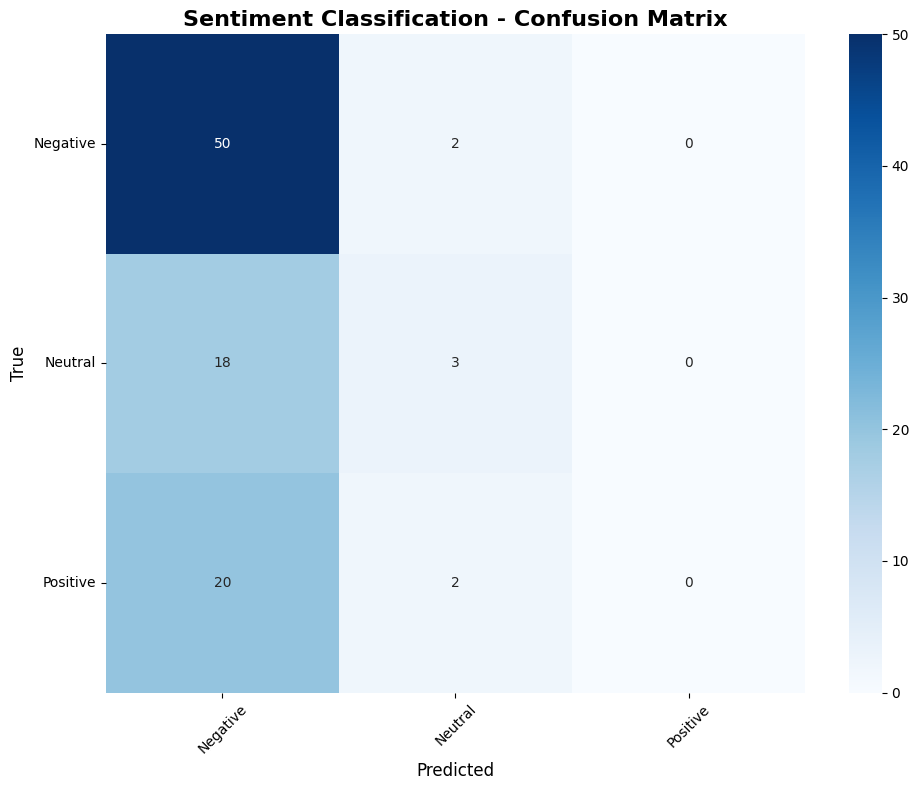

In [33]:
sentiment_results = trainer.evaluate_model(
    sentiment_model, sentiment_texts, sentiment_labels, 
    'sentiment', trainer.sentiment_label_encoder
)

# Sentiment
trainer.create_confusion_matrix(sentiment_results, 'sentiment', 'plots/roberta-sent/sentiment_confusion_matrix.png')
trainer.create_roc_curves(sentiment_results, 'sentiment', 'plots/roberta-sent/sentiment_roc_curves.png')
trainer.create_precision_recall_curves(sentiment_results, 'sentiment', 'plots/roberta-sent/sentiment_pr_curves.png')
trainer.create_learning_curves(sentiment_trainer, 'sentiment', 'plots/roberta-sent/sentiment_learning_curves.png')

In [28]:
# Assume you have these from training
# model: your trained RobertaForSequenceClassification model
# trainer: the HuggingFace Trainer object (optional, but can also be used to save)

# Save model and tokenizer to a directory
save_directory = "./roberta_sentiment_model"
sentiment_model.save_pretrained(save_directory)
trainer.tokenizer.save_pretrained(save_directory)  # or use your tokenizer object directly

('./roberta_sentiment_model\\tokenizer_config.json',
 './roberta_sentiment_model\\special_tokens_map.json',
 './roberta_sentiment_model\\vocab.json',
 './roberta_sentiment_model\\merges.txt',
 './roberta_sentiment_model\\added_tokens.json')

In [31]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load the model and tokenizer from the directory you saved
model = RobertaForSequenceClassification.from_pretrained(save_directory)
tokenizer = RobertaTokenizer.from_pretrained(save_directory)

# Put model in evaluation mode
model.eval()

import torch

# Example text
text = "I love this phone, it's amazing!"

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax(dim=-1).item()

print("Predicted class id:", predicted_class_id)

Predicted class id: 1


In [1]:
import torch
print(torch.version.cuda)  # Should show "12.1" or similar
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))  # Should print "NVIDIA GeForce RTX 4060"

12.1
True
NVIDIA GeForce RTX 4060


#### Train emotion model

In [11]:
n_emotion_classes = len(set(emotion_labels))
emotion_model, emotion_trainer = trainer.train_model(
    emotion_processed, 'emotion', n_emotion_classes
)

NameError: name 'emotion_labels' is not defined

In [ ]:
emotion_results = trainer.evaluate_model(
    emotion_model, emotion_texts, emotion_labels,
    'emotion', trainer.emotion_label_encoder
)

trainer.create_confusion_matrix(emotion_results, 'emotion', 'plots/emotion_confusion_matrix.png')
trainer.create_roc_curves(emotion_results, 'emotion', 'plots/emotion_roc_curves.png')
trainer.create_precision_recall_curves(emotion_results, 'emotion', 'plots/emotion_pr_curves.png')
trainer.create_learning_curves(emotion_trainer, 'emotion', 'plots/emotion_learning_curves.png')

### Hyperparameter Tuning

In [ ]:
sentiment_tuning_results = trainer.hyperparameter_tuning(
    sentiment_processed, 'sentiment', n_sentiment_classes
)
emotion_tuning_results = trainer.hyperparameter_tuning(
    emotion_processed, 'emotion', n_emotion_classes
)

In [24]:
trainer.save_results(sentiment_results, 'sentiment')
#trainer.save_results(emotion_results, 'emotion')

INFO:__main__:Results saved to results/roberta_sentiment_results_20250708_234846.json


## Infer models

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Path to your saved model directory
model_dir = './roberta_sentiment_model_final/'

# Load the model
model = RobertaForSequenceClassification.from_pretrained(model_dir)

# Load the tokenizer (if you want to preprocess new text)
tokenizer = RobertaTokenizer.from_pretrained(model_dir)